In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from DataProcessor import DataProcessor
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.preprocessing import StandardScaler
from Model import GaussianNaiveBayes
from Model import QuadraticDiscriminantAnalysis
# from Metrics import Metrics
from sklearn.metrics import accuracy_score
from Model import GaussianLinearClassifier
from mpl_toolkits.mplot3d import Axes3D

PCA is generally better for data reconstruction because it retains the components that explain the most variance. LDA is better for class separability and may discard information that does not contribute to distinguishing between classes, which can lead to a greater loss of information during reconstruction.

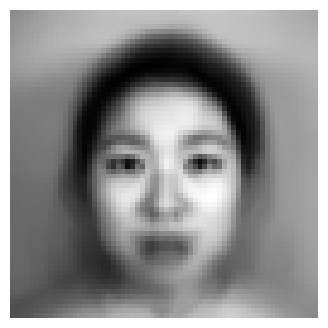

In [2]:
current_directory = os.getcwd()
image_processor = DataProcessor(current_directory)
image_processor.load_images()
image_processor.calculate_mean_image()

In [3]:
dataset = image_processor.data
images = np.array([list(img) for img in dataset['Image']])

In [4]:
labels = dataset['Expression']
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [5]:
name_classes = label_encoder.classes_

1. For each class, calculate the mean vector which summarizes the average feature value for each feature in the class.
2. Compute the Scatter Matrices
3. Compute the Linear Discriminants: The criteria for this maximization is typically the generalized eigenvalue problem for $ S_W^{-1}S_B  $
4. Project the Data 

Limitations:
- Assumes Gaussian Distributions: Works best when the data distribution is approximately normal.
- Sensitivity to Outliers: Can be influenced heavily by outliers in the data.
- Linear Separability: Assumes that the classes can be separated by a linear boundary.

In [6]:
def data_whitening(X, mean, std):
    X = X - mean
    X = X / (std + 1e-10)
    return X

In [7]:
def inverse_data_whitening(X, mean, std):
    X = X * std
    X = X + mean
    return X

In [8]:
X, y = images, labels
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X_standardized = data_whitening(X, mean, std)

Within-class scatter matrix:

$$ S_W = \sum_{i=1}^{c} S_i = \sum_{i=1}^{c} \sum_{\mathbf{x} \in D_i} (\mathbf{x} - \mathbf{m}_i)(\mathbf{x} - \mathbf{m}_i)^T $$
  

In [9]:
def within_scatter(X,y):
    Sw = np.zeros((X.shape[1], X.shape[1]))
    N = X.shape[0]
    for i in np.unique(y):
        Xi = X[y == i]
#         mean_class = np.mean(Xi, axis=0)
#         Si = np.dot((Xi - mean_class).T, (Xi - mean_class))
        Si = np.cov(Xi, rowvar=False) * (len(Xi) -1 )
        Sw += Si
    return  Sw


Between-class scatter matrix:
$$
  S_B = \sum_{i=1}^{c} N_i (\mathbf{m}_i - \mathbf{m})(\mathbf{m}_i - \mathbf{m})^T
$$

In [10]:
def between_scatter(X, y, mean_overall):
    mean_overall = np.mean(X, axis=0)    
    unique_classes = np.unique(y)
    Sb = np.zeros((X.shape[1], X.shape[1]))
    for i in unique_classes:
        Xi = X[y == i]
        mean_class_i = Xi.mean(axis=0)
        Ni = len(Xi)
        mean_diff = mean_class_i - mean_overall
        Sb += Ni * np.outer(mean_diff, mean_diff)
    return Sb


In [11]:
mean_overall = np.mean(X_standardized, axis=0)

In [12]:
Sw = within_scatter(X_standardized, labels)
Sb = between_scatter(X_standardized, labels, mean_overall)

make sw and sb symmetric
to counteract any numerical instability that might result in non-symmetric scatter matrices due to floating-point errors.

In [13]:
# Sw = (Sw + Sw.T) / 2
# Sb = (Sb + Sb.T) / 2

Solve the Eigenvalue Problem
$$ S_W^{-1}S_B \mathbf{w} = \lambda \mathbf{w} $$



In [14]:
def regularized_inverse(matrix, alpha=0.01):
    reg_matrix = matrix + alpha * np.eye(matrix.shape[0])
    return np.linalg.pinv(reg_matrix)

In [15]:
def calculate_separability_matrix(Sw, Sb):
    Sw_inv = regularized_inverse(Sw)
    return Sw_inv.dot(Sb)

In [16]:
def plot_eigenfaces(eigenfaces):
    num_eigenfaces = len(eigenfaces)
    num_rows = int(np.ceil(num_eigenfaces / 5))
    num_columns = min(5, num_eigenfaces)
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(3 * num_columns, 3 * num_rows))
    for i in range(num_rows):
        for j in range(num_columns):
            index = i * num_columns + j
            if index < num_eigenfaces:
                ax = axes[i, j] if num_rows > 1 else axes[j]
                ax.imshow(eigenfaces[index], cmap='gray')
                ax.axis('off')

    plt.show()

In [17]:
def inverse_transform(X, components, mean, std):
    return inverse_data_whitening(np.dot(X, components), mean, std)

In [18]:
def plot_inverse_transformation(reconstructed_images, unique_classes, image_size):
    
    print("inverse transform images: ")
    fig, axes = plt.subplots(2, len(unique_classes), figsize=(4* len(unique_classes),12))
    for i, class_label in enumerate(unique_classes):
        class_indices = np.where(labels == class_label)[0]
        random_index = np.random.choice(class_indices)
        original_image = images[random_index].reshape(image_size)
        reconstructed_image = reconstructed_images[random_index]

        axes[0, i].imshow(original_image, cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Class {class_label} - Original')

        axes[1,i].imshow(reconstructed_image, cmap='gray')
        axes[1,i].axis('off')
        axes[1,i].set_title(f'Class {class_label} - Reconstructed')

    plt.tight_layout()
    plt.show()

In [19]:
separability_matrix = calculate_separability_matrix(Sw, Sb)

In [20]:
eigenvalues, eigenvectors = np.linalg.eig(separability_matrix)

This null space represents directions in the feature space along which the projection does not help to separate the classes any further because these directions do not contribute to between-class variance.

In [21]:
eigenvectors = eigenvectors.T
idxs = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idxs]
eigenvectors = eigenvectors[idxs]

In [22]:
image_size = (64,64)
n_components = min(len(np.unique(labels)), eigenvectors.shape[1]) - 1 
# components = np.real(eigenvectors[0:n_components])
components = eigenvectors[:n_components]
transformed_images = X_standardized.dot(components.T)
eigenfaces = components.reshape((n_components, *image_size))

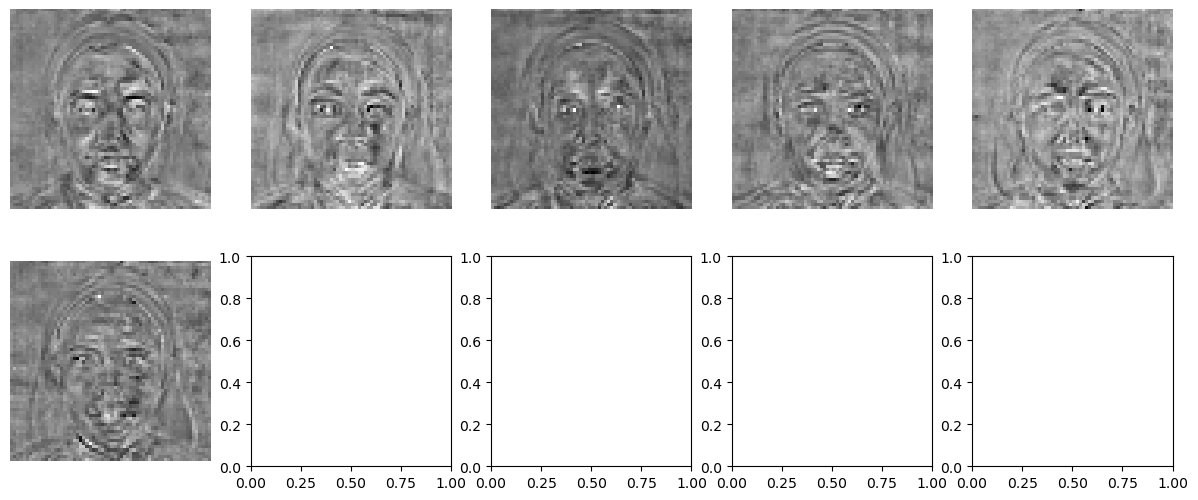

In [23]:
plot_eigenfaces(eigenfaces)

In [24]:
labels = y
unique_classes = list(set(labels))
reconstructed_images = inverse_transform(transformed_images,components, mean, std)
reconstructed_images = reconstructed_images.reshape(-1, *image_size)

In [25]:
name_classes

array(['AN', 'DI', 'FE', 'HA', 'NE', 'SA', 'SU'], dtype=object)

inverse transform images: 


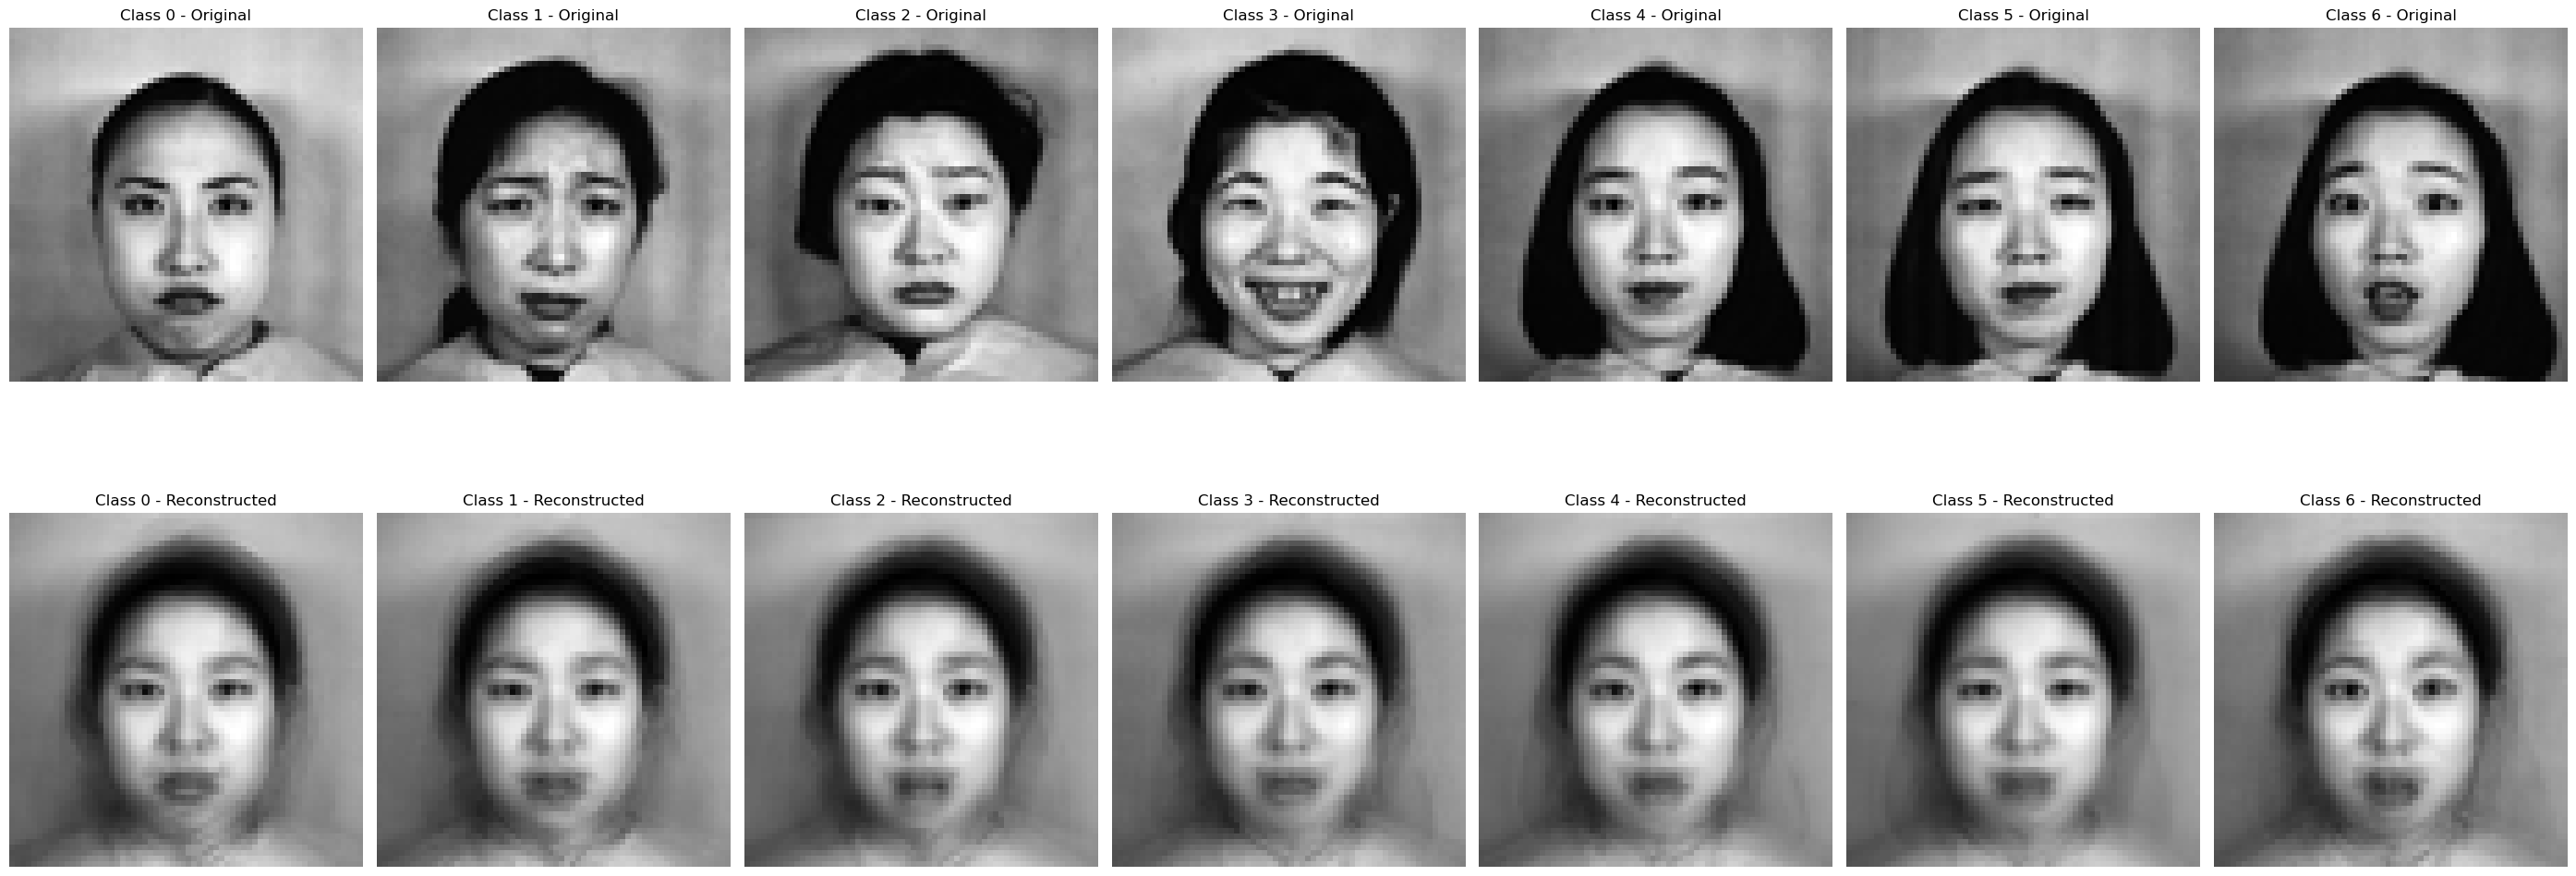

In [26]:
plot_inverse_transformation(reconstructed_images, unique_classes, image_size)

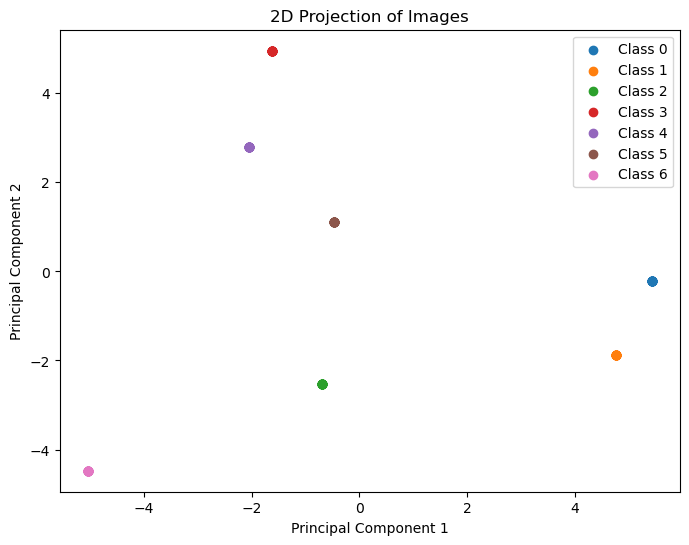

In [27]:
fig = plt.figure(figsize=(8, 6))
for class_label in unique_classes:
    class_indices = np.where(labels == class_label)[0]
    plt.scatter(transformed_images[class_indices, 0], transformed_images[class_indices, 1], label=f'Class {class_label}')

plt.title('2D Projection of Images')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

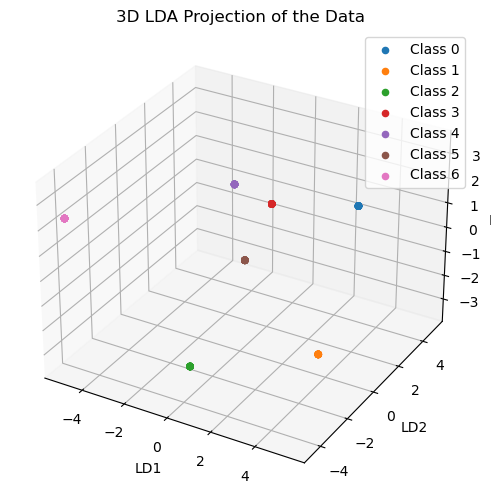

In [28]:
if transformed_images.shape[1] >= 3:
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    for label in np.unique(labels):
        ax.scatter(transformed_images[labels == label, 0], transformed_images[labels == label, 1], transformed_images[labels == label, 2], label=f'Class {label}')
    ax.set_title('3D LDA Projection of the Data')
    ax.set_xlabel('LD1')
    ax.set_ylabel('LD2')
    ax.set_zlabel('LD3')
    plt.legend()
    plt.show()
    
else:
    print("Cannot plot in 3D as there are less than 3 dimensions.")

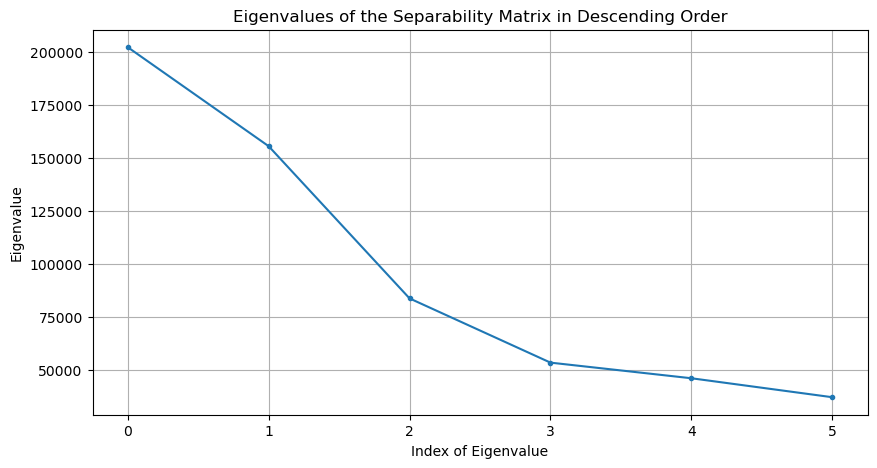

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(eigenvalues[:len(unique_classes) - 1], 'o-', markersize=3)
plt.title('Eigenvalues of the Separability Matrix in Descending Order')
plt.xlabel('Index of Eigenvalue')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.show()

In [30]:
X_train, X_test, y_train, y_test = train_test_split(transformed_images, y, test_size=0.3, random_state=42)

In [32]:
qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(X_train, y_train)
y_pred = qda_model.predict_likelihood(X_test)
accuracy_value = accuracy_score(y_test, y_pred)
print(f"QDA Accuracy: {accuracy_value:.2f}")

QDA Accuracy: 1.00


In [33]:
gnb = GaussianNaiveBayes()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
accuracy_value = accuracy_score(y_test, y_pred)
print(f"Naive Bayes Accuracy: {accuracy_value:.2f}")

Naive Bayes Accuracy: 1.00


In [34]:
X_train, X_test, y_train, y_test = train_test_split(transformed_images, y, test_size=0.3, random_state=42)

If there's an increase in accuracy when adding the second feature, this implies that the second feature provides additional valuable discriminative information that wasn't captured by the first feature alone.
The maximum number of components (or dimensions) that LDA can extract is C - 1, where C is the number of classes. 
This is because the goal of LDA is to maximize the variance between classes while minimizing the variance within each class. After C - 1 dimensions, you've already used all the axes that provide separation between the classes, and additional axes do not provide further separation.

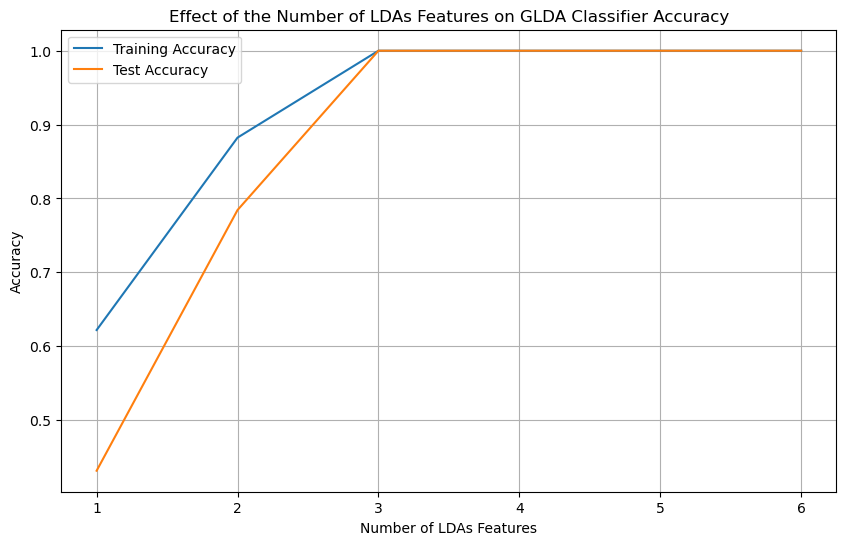

In [35]:
max_num_features = min(len(np.unique(y)) - 1, X_standardized.shape[1])
num_features = range(1, max_num_features + 1)
train_accuracies = []
test_accuracies = []
feature_numbers = []

for num in num_features:
    X_train, X_test, y_train, y_test = train_test_split(transformed_images[:,:num], y, test_size=0.3, random_state=42)
    classifier = GaussianLinearClassifier()
    classifier.fit(X_train, y_train)

    # Training accuracy
    y_train_pred = classifier.predict_likelihood(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)

    # Test accuracy
    y_test_pred = classifier.predict_likelihood(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(num_features, train_accuracies, label='Training Accuracy')
plt.plot(num_features, test_accuracies, label='Test Accuracy')
plt.xlabel('Number of LDAs Features')
plt.ylabel('Accuracy')
plt.title('Effect of the Number of LDAs Features on GLDA Classifier Accuracy')
plt.legend()
plt.grid(True)
plt.show()


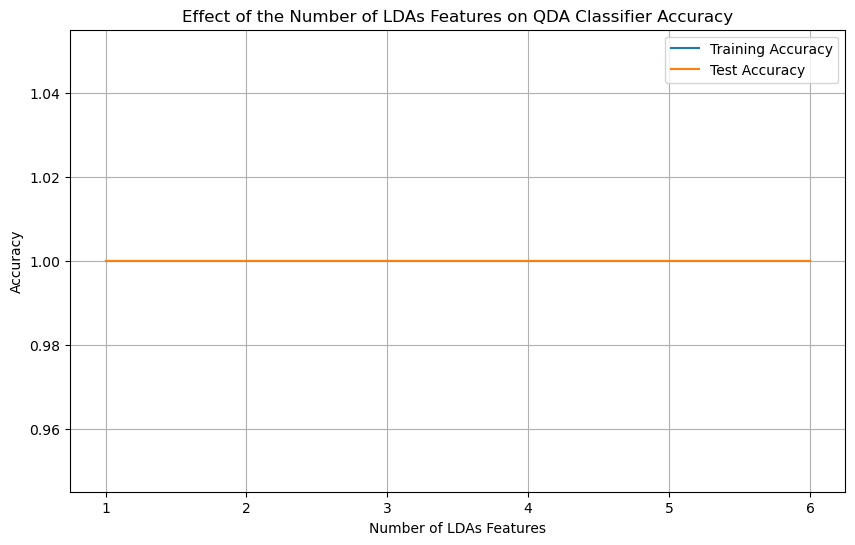

In [36]:
max_num_features = min(len(np.unique(y)) - 1, X_standardized.shape[1])
num_features = range(1, max_num_features + 1)
train_accuracies = []
test_accuracies = []
feature_numbers = []

for num in num_features:
    X_train, X_test, y_train, y_test = train_test_split(transformed_images[:,:num], y, test_size=0.3, random_state=42)
    classifier = QuadraticDiscriminantAnalysis()
    classifier.fit(X_train, y_train)

    # Training accuracy
    y_train_pred = classifier.predict_likelihood(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)

    # Test accuracy
    y_test_pred = classifier.predict_likelihood(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(num_features, train_accuracies, label='Training Accuracy')
plt.plot(num_features, test_accuracies, label='Test Accuracy')
plt.xlabel('Number of LDAs Features')
plt.ylabel('Accuracy')
plt.title('Effect of the Number of LDAs Features on QDA Classifier Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
import numpy as np
import matplotlib.pyplot as plt

X1 = np.array([[4,1], [2,4], [2,3], [3,6], [4,4]])
X2 = np.array([[9,10], [6,8], [9,5], [8,7], [10,8]])

mu1 = np.mean(X1, axis=0)
std1 = np.std(X1, axis=0)
mu2 = np.mean(X2, axis=0)

S1 = np.dot((X1 - mu1).T , (X1 - mu1))
S2 = np.dot((X2 - mu2).T, (X2 - mu2))
Sw = S1 + S2
Sw_inv = np.linalg.inv(Sw)
print(np.linalg.eig(np.dot(Sw_inv,Sb))[0])
Sb = np.outer((mu1 - mu2), (mu1 - mu2))


S1, S2, Sb, Sw, mu1, mu2


[3.13137004e+00 6.60542423e-18]


(array([[ 4. , -2. ],
        [-2. , 13.2]]),
 array([[ 9.2, -0.2],
        [-0.2, 13.2]]),
 array([[29.16, 21.6 ],
        [21.6 , 16.  ]]),
 array([[13.2, -2.2],
        [-2.2, 26.4]]),
 array([3. , 3.6]),
 array([8.4, 7.6]))

In [38]:
X = np.array([[4,1], [2,4], [2,3], [3,6], [4,4],[9,10], [6,8], [9,5], [8,7], [10,8]])
y = [0,0,0,0,0,1,1,1,1,1]
Sw = within_scatter(X,y)
Sb = between_scatter(X,y,1)

In [39]:
Sw

array([[13.2, -2.2],
       [-2.2, 26.4]])

In [40]:
Sb

array([[72.9, 54. ],
       [54. , 40. ]])

In [41]:
Sw_inverse = np.linalg.inv(Sw)
is_symmetric = np.array_equal(Sw_inverse, Sw_inverse.T)
if is_symmetric:
    print("The matrix is symmetric.")
else:
    print("The matrix is not symmetric.")

The matrix is symmetric.
